In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geopy.distance import geodesic as GD
from collections import Counter
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
from matplotlib import cm
import pandas as pd
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import random
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind
from plotnine import *
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
real_address = '../../data/Same_ET_ST_result/Network1_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network1_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
f_real.close()

in_degree = np.zeros((73,144))
out_degree = np.zeros((73,144))

for m in range (0,73,1):
    for n in range (0,144,1):

        in_degree_value = 0
        out_degree_value = 0

        for p in range (0,73,1):
            for q in range (0,144,1):
                if SC_ij[m,n,p,q] == 0:
                    continue
                else:
                    if dis[m,n,p,q]<=4000:
                        in_degree_value += SC_ji[m,n,p,q]*np.cos(lat[p]*np.pi/180)
                        out_degree_value += SC_ij[m,n,p,q]*np.cos(lat[p]*np.pi/180)

                    else:
                        continue
        in_degree[m,n] = in_degree_value
        out_degree[m,n] = out_degree_value

In [3]:
divergence = out_degree-in_degree

In [4]:
real_address = '../../data/Same_ET_ST_result/Network1_SC_in_out.h5'

f_real = h5py.File(real_address,'r')
SC_ij = f_real['SC_ij'][:]
SC_ji = f_real['SC_ji'][:]
lat = f_real['lat'][:]
lon = f_real['lon'][:]
f_real.close()

real_address = '../../data/Same_ET_ST_result/Network1_SC.h5'

f_real = h5py.File(real_address,'r')
dis = f_real['dis'][:]
asy = f_real['asy'][:]
f_real.close()


def out_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            outk = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]>0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                outk = outk + (SC_ij[m,n,p,q]-SC_ji[m,n,p,q])*np.cos(lat[p]*np.pi/180)*e_1
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = outk[0]
            y_axes[m][n] = outk[1]
    
    return x_axes,y_axes

def in_weighted_direction(SC_ij,SC_ji,asy,dis):

    x_axes = np.zeros((len(lat),len(lon)))
    y_axes = np.zeros((len(lat),len(lon)))

    for m in range(0,(len(lat)),1):
        for n in range (0,(len(lon)),1):

            ink = np.array([0,0])

            for p in range(0,(len(lat)),1):
                for q in range (0,(len(lon)),1):

                    if SC_ij[m,n,p,q] == 0:
                        continue
                    else:
                        if dis[m,n,p,q] <= 4000:
                            if asy[m,n,p,q]<0:

                                lat_diff = lat[p] - lat[m]
                                lon_diff = (lon[q] - lon[n] + 180) % 360 - 180
                                eij = np.array([lon_diff,lat_diff])
                                e_1 = eij/np.linalg.norm(eij)

                                ink = ink + (SC_ji[m,n,p,q]-SC_ij[m,n,p,q])*np.cos(lat[p]*np.pi/180)*(-e_1)
                            else:
                                continue                        
                        else:
                            continue               

            x_axes[m][n] = ink[0]
            y_axes[m][n] = ink[1]
    
    return x_axes,y_axes

In [5]:
V_out_x,V_out_y = out_weighted_direction(SC_ij,SC_ji,asy,dis)
V_in_x,V_in_y = in_weighted_direction(SC_ij,SC_ji,asy,dis)

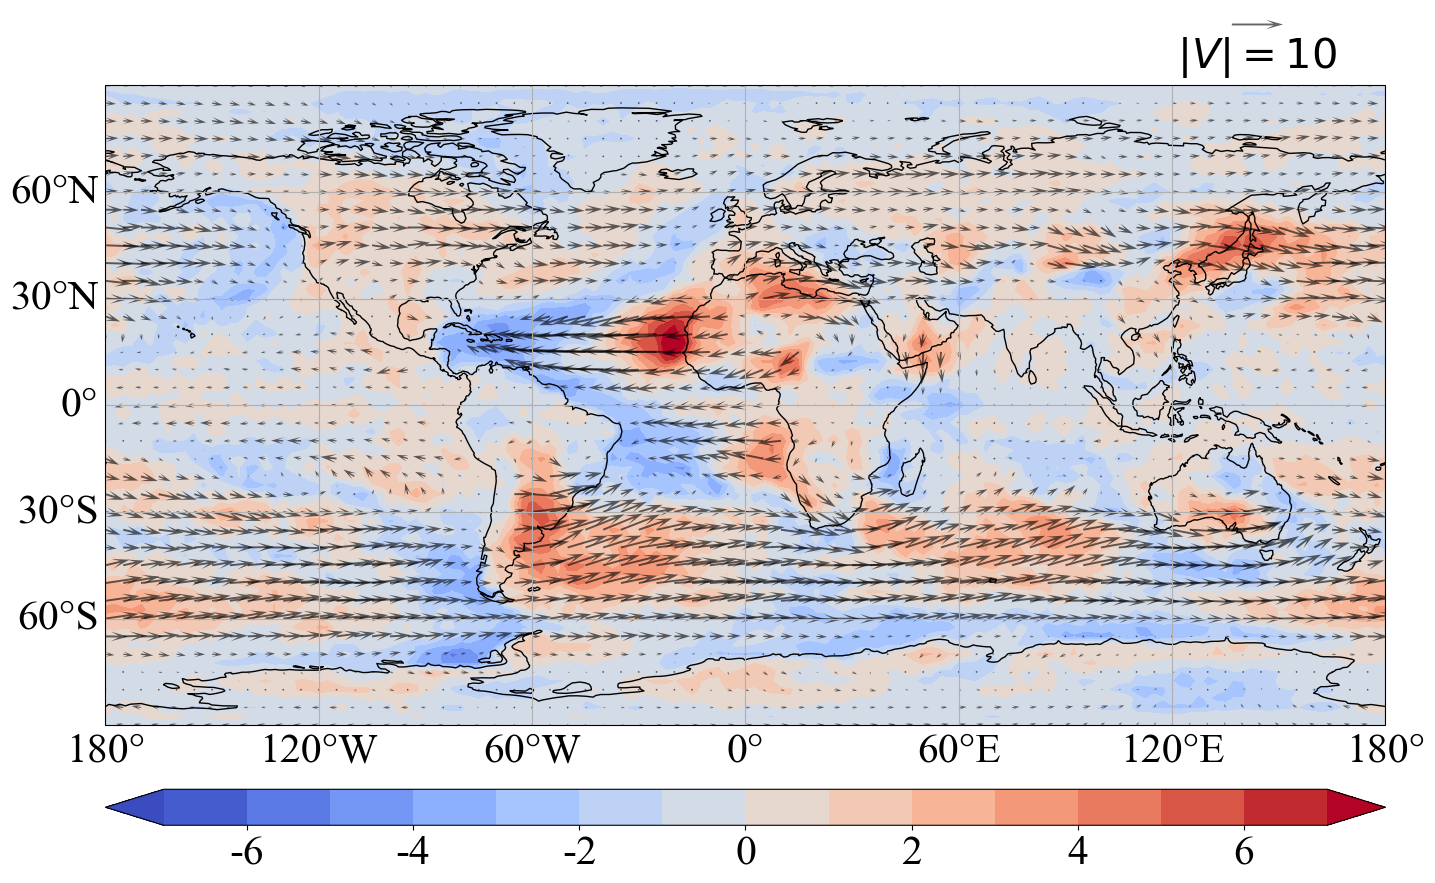

In [7]:
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.6],projection = ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'))
gl = ax1.gridlines(draw_labels=True,x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}

cyclic_data,cyclic_lon = add_cyclic_point(divergence,coord=lon)
c1 = ax1.contourf(cyclic_lon,lat,cyclic_data,cmap=cm.coolwarm,levels = np.linspace(-8,8,15),extend = 'both',transform = ccrs.PlateCarree())
colorbar = fig.add_axes([0.1,0.05,0.8,0.03])
cbar = fig.colorbar(c1,cax=colorbar,orientation='horizontal',format = '%d') 
cbar.ax.tick_params(labelsize=30)

q1 = ax1.quiver(lon[::2],lat[::2],V_out_x[::2,::2],V_out_y[::2,::2],scale=250,transform=ccrs.PlateCarree(),width=0.0015,color='black',
                headwidth=5,headlength = 9,headaxislength = 5,alpha=0.6)
'''
for i in range (0,len(lat),3):
    for j in range (0,len(lon),3):
        start_lat = lat[i]-V_in_y[i,j]
        start_lon = lon[j]-V_in_x[i,j]
        q2=ax1.quiver(start_lon,start_lat,V_in_x[i,j],V_in_y[i,j],scale=200,transform=ccrs.PlateCarree(),width=0.0015,color='#4069FE')
'''

ax1.quiverkey(q1, 0.9, 1.095, 10, label =  r"$|V|=10$",labelpos='S',coordinates='axes',fontproperties={'size': 30})
#ax1.quiverkey(q2, 0.73, 1.095, 10, label = r"$|V^{in}|=10$",labelpos='S',coordinates='axes',fontproperties={'size': 30})
ax1.set_title(' \n \n \n ')
plt.savefig("FIG/FIGS3/FIGS3.svg", bbox_inches='tight', dpi=400, transparent=True)
plt.show()